### For development, testing and debugging of complete null filtering experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats import multitest
from statsmodels.stats.multitest import fdrcorrection_twostage, fdrcorrection
import copy

import sys
sys.path.insert(1, "../code/utils")
from celldata import *

import multiprocessing
from joblib import Parallel, delayed

In [2]:
pathGF = "../../../PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")][:6]
for i in  range(len(filenamesGF)):print(filenamesGF[i])

cellshilicnegGFstatus.csv
cellshilicposGFstatus.csv
cellslipidnegGFstatus.csv
cellslipidposGFstatus.csv
cellsRPnegGFstatus.csv
cellsRPposGFstatus.csv


In [3]:
fnum=0
data = compile_ttest_features(pathGF,filenamesGF[fnum])
area = data['AREA']
gaps = data['GAPS']

Reading data from: ../../../PDproj/celldata/datawithGFstatus/clean/cellshilicnegGFstatus.csv


In [33]:

# READY TO USE
def global_null_experimentV1(X,n_iter, alpha=0.05, filter=None, equal_var=True, keep_k=0, TAG='UNKNOWN'):
    # Filtering is applied to the data before the t-test, only one filter is applied
    # negative keep_k means that all p-values are kept, zero means none are kept, and positive means k are kept
    
    if filter is None:
        filter = lambda x: x
        
    FD_bh = np.zeros(n_iter,dtype=int)
    FD_by = np.zeros(n_iter,dtype=int)
    FD_bh_2step = np.zeros(n_iter,dtype=int)
    FD_bky_2step = np.zeros(n_iter,dtype=int)
    FD_bonf = np.zeros(n_iter,dtype=int)
    FD_unadj = np.zeros(n_iter,dtype=int)
    
    flag=False
    if keep_k == -1:
        flag=True
        pvalues = -1.0*np.ones((n_iter, X.shape[0]))
    elif keep_k > 0:
        pvalues = np.zeros((n_iter, keep_k))
    else:
        pvalues=None
        
    counts = np.zeros(n_iter,dtype=int)
    m0_estimates_bh = np.zeros(n_iter)
    m0_estimates_bky = np.zeros(n_iter)
    
    for i in range(n_iter):
        x_perm = X.flatten()
        x_perm = np.random.permutation(x_perm).reshape(X.shape)
        x_perm = filter(x_perm)
        x_perm = compile_pairwise_comparisons_legacy(x_perm)
        
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        # NOTE: sorting here is saving compute time, but it is not necessary
        # if no sorting is done here, then change is_sorted=False in the following functions
        pvals = np.sort(pvals)
        counts[i] = len(pvals)
        
        if pvalues is not None:
            k = np.min([len(pvals), pvalues.shape[1]])
            pvalues[i,:k] = pvals[:k]
        
        FD_bonf[i] = multitest.multipletests(pvals, alpha=alpha, method='bonferroni', is_sorted=True)[0].sum()
        FD_unadj[i] = (pvals < alpha).sum()
        FD_bh[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)[0].sum()
        FD_by[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_by', is_sorted=True)[0].sum()
        
        m0_estimate_bh, alpha_adjusted = estimate_m0_bh(pvals, alpha=alpha, is_sorted=True)
        FD_bh_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bh[i] = m0_estimate_bh
        
        m0_estimate_bky, alpha_adjusted = estimate_m0_bky(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)
        FD_bky_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bky[i] = m0_estimate_bky
        #FD_bh_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bh')[0].sum()
        #FD_bky_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bky', iter=True)[0].sum()
        
    if flag:
        # flatten and remove -1.0
        pvalues = pvalues.flatten()
        pvalues = pvalues[pvalues != -1.0]    
    
    # return everything in a dictionary
    return {'TAG':TAG,'BH':{'FD': FD_bh},
            'BY':{'FD': FD_by},
            'BH_2STEP':{'FD': FD_bh_2step},
            'BKY_2STEP':{'FD': FD_bky_2step},
            'BONF':{'FD': FD_bonf},
            'UNADJ':{'FD': FD_unadj},
            'pvalues': pvalues,
            'n_tests': counts,
            'm0_estimates_bh': m0_estimates_bh,
            'm0_estimates_bky': m0_estimates_bky}
            
# READY TO USE
def global_null_experimentV2(X, GAPS, n_iter=1e4, alpha=0.05, k=10, filter=None, equal_var=True, keep_k=0, TAG='UNKNOWN'):
    # 2 filters are applied to the data before the t-test, one based on data and one based on reliability (gaps)
    
    if filter is None:
        filter = lambda x: (x,np.arange(x.shape[0]))
        
    FD_bh = np.zeros(n_iter,dtype=int)
    FD_by = np.zeros(n_iter,dtype=int)
    FD_bh_2step = np.zeros(n_iter,dtype=int)
    FD_bky_2step = np.zeros(n_iter,dtype=int)
    FD_bonf = np.zeros(n_iter,dtype=int)
    FD_unadj = np.zeros(n_iter,dtype=int)
    
    flag=False
    if keep_k == -1:
        flag=True
        pvalues = -1.0*np.ones((n_iter, keep_k))
    elif keep_k > 0:
        pvalues = np.zeros((n_iter, keep_k))
    else:
        pvalues=None
    
    counts = np.zeros(n_iter,dtype=int)
    m0_estimates_bh = np.zeros(n_iter)
    m0_estimates_bky = np.zeros(n_iter)
    
    for i in range(n_iter):
        x_perm = X.flatten()
        gaps_perm = GAPS.flatten()
        random_perm = np.random.permutation(len(x_perm))
        x_perm = x_perm[random_perm].reshape(X.shape)
        gaps_perm = gaps_perm[random_perm].reshape(GAPS.shape)
        
        x_perm, inds = filter(x_perm)
        gaps_perm = gaps_perm[inds]
        x_perm = compile_pairwise_comparisons_legacy(x_perm)
        gaps_perm = compile_pairwise_comparisons_legacy(gaps_perm)
        inds = reliability(gaps_perm[:,:10], gaps_perm[:,10:], 0.8, [0,8,64,128])[0]
        x_perm = x_perm[inds]
        
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        pvals = np.sort(pvals)
        counts[i] = len(pvals)
        
        if pvalues is not None:
            k = np.min([len(pvals), pvalues.shape[1]])
            pvalues[i,:k] = pvals[:k]
        
        FD_bonf[i] = multitest.multipletests(pvals, alpha=alpha, method='bonferroni', is_sorted=True)[0].sum()
        FD_unadj[i] = (pvals < alpha).sum()
        FD_bh[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)[0].sum()
        FD_by[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_by', is_sorted=True)[0].sum()
        
        m0_estimate_bh, alpha_adjusted = estimate_m0_bh(pvals, alpha=alpha, is_sorted=True)
        FD_bh_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bh[i] = m0_estimate_bh
        
        m0_estimate_bky, alpha_adjusted = estimate_m0_bky(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)
        FD_bky_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bky[i] = m0_estimate_bky
        
        #FD_bh_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bh')[0].sum()
        #FD_bky_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bky')[0].sum()
        
    if flag:
        # flatten and remove -1.0
        pvalues = pvalues.flatten()
        pvalues = pvalues[pvalues != -1.0]
    
    return {'TAG':TAG,'BH':{'FD': FD_bh},
            'BY':{'FD': FD_by},
            'BH_2STEP':{'FD': FD_bh_2step},
            'BKY_2STEP':{'FD': FD_bky_2step},
            'BONF':{'FD': FD_bonf},
            'UNADJ':{'FD': FD_unadj},
            'pvalues': pvalues,
            'n_tests': counts,
            'm0_estimates_bh': m0_estimates_bh,
            'm0_estimates_bky': m0_estimates_bky}

# READY TO USE
def global_null_experimentV3(X, GAPS, n_iter=1e4, alpha=0.05, k=10, filter=None, equal_var=True, keep_k=0, TAG='UNKNOWN'):
    # 3 filters are applied to the data before the t-test, one based on data, one based on reliability (gaps), and one based on the Fisher's exact test
    # Fisher's test is approximated here by a very conservative 10-to-0 or 0-to-10 test

    if filter is None:
        filter = lambda x: (x,np.arange(x.shape[0]))
        
    FD_bh = np.zeros(n_iter,dtype=int)
    FD_by = np.zeros(n_iter,dtype=int)
    FD_bh_2step = np.zeros(n_iter,dtype=int)
    FD_bky_2step = np.zeros(n_iter,dtype=int)
    FD_bonf = np.zeros(n_iter,dtype=int)
    FD_unadj = np.zeros(n_iter,dtype=int)
    FD_fisher = np.zeros(n_iter,dtype=int)
    
    flag=False
    if keep_k == -1:
        flag=True
        pvalues = -1.0*np.ones((n_iter, keep_k))
    elif keep_k > 0:
        pvalues = np.zeros((n_iter, keep_k))
    else:
        pvalues=None
    
    counts = np.zeros(n_iter,dtype=int)
    m0_estimates_bh = np.zeros(n_iter)
    m0_estimates_bky = np.zeros(n_iter)
    
    for i in range(n_iter):
        x_perm = X.flatten()
        gaps_perm = GAPS.flatten()
        random_perm = np.random.permutation(len(x_perm))
        x_perm = x_perm[random_perm].reshape(X.shape)
        gaps_perm = gaps_perm[random_perm].reshape(GAPS.shape)
        
        x_perm, inds = filter(x_perm)
        gaps_perm = gaps_perm[inds]
        x_perm = compile_pairwise_comparisons_legacy(x_perm)
        gaps_perm = compile_pairwise_comparisons_legacy(gaps_perm)
        inds, counts1, counts2 = reliability(gaps_perm[:,:10], gaps_perm[:,10:], 0.8, [0,8,64,128])
        inds = np.logical_and(counts1 ==10, counts2 ==0) | np.logical_and(counts1 == 0, counts2 == 10)
        fd_fisher = inds.sum()
        inds = ~inds
        x_perm = x_perm[inds]
        
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        pvals = np.sort(pvals)
        counts[i] = len(pvals)
        
        if pvalues is not None:
            k = np.min([len(pvals), pvalues.shape[1]])
            pvalues[i,:k] = pvals[:k]
        
        FD_fisher[i] = fd_fisher
        FD_bonf[i] = multitest.multipletests(pvals, alpha=alpha, method='bonferroni', is_sorted=True)[0].sum()
        FD_unadj[i] = (pvals < alpha).sum()
        FD_bh[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)[0].sum()
        FD_by[i] = multitest.multipletests(pvals, alpha=alpha, method='fdr_by', is_sorted=True)[0].sum()
        
        m0_estimate_bh, alpha_adjusted = estimate_m0_bh(pvals, alpha=alpha, is_sorted=True)
        FD_bh_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bh[i] = m0_estimate_bh
        
        m0_estimate_bky, alpha_adjusted = estimate_m0_bky(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)
        FD_bky_2step[i] = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=True)[0].sum()
        m0_estimates_bky[i] = m0_estimate_bky
        
        #FD_bh_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bh')[0].sum()
        #FD_bky_2step[i] = fdrcorrection_twostage(pvals, alpha=alpha, method='bky')[0].sum()
        
    if flag:
        # flatten and remove -1.0
        pvalues = pvalues.flatten()
        pvalues = pvalues[pvalues != -1.0]
    
    return {'TAG':TAG,'BH':{'FD': FD_bh},
            'BY':{'FD': FD_by},
            'BH_2STEP':{'FD': FD_bh_2step},
            'BKY_2STEP':{'FD': FD_bky_2step},
            'BONF':{'FD': FD_bonf},
            'UNADJ':{'FD': FD_unadj},
            'FISHER':{'FD': FD_fisher},
            'pvalues': pvalues,
            'n_tests': counts,
            'm0_estimates_bh': m0_estimates_bh,
            'm0_estimates_bky': m0_estimates_bky}
    
    
# READY TO USE
def global_null_resampling_experimentV1(X, n_iter, n_iter_inner=1000,\
                                         alpha=0.05, filter=None, equal_var=True, full_resampling=False, TAG='UNKNOWN'):

    if filter is None:
        filter = lambda x: x
        
    counts = np.zeros(n_iter,dtype=int)
    FD_wy = np.zeros(n_iter,dtype=int)
    FD_reiner_bh = np.zeros(n_iter,dtype=int)
    FD_reiner_by = np.zeros(n_iter,dtype=int)
    
    for i in range(n_iter):
        x_perm = X.flatten()
        x_perm = np.random.permutation(x_perm).reshape(X.shape)
        x_perm = filter(x_perm)
        
        # full resampling means that we permute across all samples and groups
        if full_resampling:
            # resampling procedure has to use same ordering of pairwise comparisons as the following t-tests
            _, __, resampled_stats, max_stats = westfall_young_resampled_pvalues_full(x_perm, n_iter=n_iter_inner, equal_var=equal_var)
            # compile pairwise comparisons using same methods as is done within westfall_young_resampled_pvalues
            x_perm = compile_pairwise_comparisons_legacy(x_perm)
        else:
            # compile pairwise comparisons before resampling
            x_perm = compile_pairwise_comparisons_legacy(x_perm)
            _, __, resampled_stats, max_stats = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner, equal_var=equal_var)        
        
        #pval_wy = np.sort(min_pvals)[int(alpha*n_iter_inner)]
        stat_wy = np.sort(max_stats)[::-1][int(alpha*n_iter_inner)]
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var)
        pvals = result.pvalue
        statistics = result.statistic
        #adjusted_pvals_reiner, adjusted_pvals_marginal = resampling_adjusted_pvalues(pvals, resampled_pvals)
        adjusted_pvals_reiner = resampling_adjusted_pvalues_from_stats(statistics, resampled_stats)
        
        
        counts[i] = len(pvals)
        #FD_wy[i] = (pvals < pval_wy).sum()
        FD_wy[i] = (np.abs(statistics) > stat_wy).sum()
        FD_reiner_bh[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_bh')[0].sum()
        FD_reiner_by[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_by')[0].sum()
        
    return {'TAG':TAG,'WY':{'FD': FD_wy},
            'REINER_BH':{'FD': FD_reiner_bh},
            'REINER_BY':{'FD': FD_reiner_by},
            'n_tests': counts}

# READY TO USE
def global_null_resampling_experimentV2(X, GAPS, n_iter=1e4, n_iter_inner=1000,\
                                         alpha=0.05, k=10, filter=None, equal_var=True, TAG='UNKNOWN'):
    
    if filter is None:
        filter = lambda x: (x,np.arange(x.shape[0]))
            
    counts = np.zeros(n_iter,dtype=int)
    FD_wy = np.zeros(n_iter,dtype=int)
    FD_reiner_bh = np.zeros(n_iter,dtype=int)
    FD_reiner_by = np.zeros(n_iter,dtype=int)
        
    for i in range(n_iter):
        x_perm = X.flatten()
        gaps_perm = GAPS.flatten()
        random_perm = np.random.permutation(len(x_perm))
        x_perm = x_perm[random_perm].reshape(X.shape)
        gaps_perm = gaps_perm[random_perm].reshape(GAPS.shape)
        
        x_perm, inds = filter(x_perm)
        gaps_perm = gaps_perm[inds]
        gaps_perm = compile_pairwise_comparisons_legacy(gaps_perm)            
        inds = reliability(gaps_perm[:,:10], gaps_perm[:,10:], 0.8, [0,8,64,128])[0]
            
        # compile pairwise comparisons before resampling, and using only the reliable tests
        x_perm = compile_pairwise_comparisons_legacy(x_perm)
        x_perm = x_perm[inds]
        #resampled_pvals, min_pvals, _ = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner)
        _, __, resampled_stats, max_stat = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner)
            
        #pval_wy = np.sort(min_pvals)[int(alpha*n_iter_inner)]
        stat_wy = np.sort(max_stat)[::-1][int(alpha*n_iter_inner)]
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var)
        pvals = result.pvalue
        statistics = result.statistic
        #adjusted_pvals_reiner, adjusted_pvals_marginal = resampling_adjusted_pvalues(pvals, resampled_pvals)
        adjusted_pvals_reiner = resampling_adjusted_pvalues_from_stats(statistics, resampled_stats)
         
        counts[i] = len(pvals)
        #FD_wy[i] = (pvals < pval_wy).sum()
        FD_wy[i] = (np.abs(statistics) > stat_wy).sum()
        FD_reiner_bh[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_bh')[0].sum()
        FD_reiner_by[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_by')[0].sum()
            
    return {'TAG':TAG,'WY':{'FD': FD_wy},
            'REINER_BH':{'FD': FD_reiner_bh},
            'REINER_BY':{'FD': FD_reiner_by},
            'n_tests': counts}
            
# READY TO USE
def global_null_resampling_experimentV3(X, GAPS, n_iter=1e4, n_iter_inner=1000, alpha=0.05, k=10, filter=None, equal_var=True):
    # like the previous, but now we also include the Fisher's exact test
    if filter is None:
        filter = lambda x: (x,np.arange(x.shape[0]))
        
    counts = np.zeros(n_iter,dtype=int)
    FD_wy = np.zeros(n_iter,dtype=int)
    FD_reiner_bh = np.zeros(n_iter,dtype=int)
    FD_reiner_by = np.zeros(n_iter,dtype=int)
    FD_fisher = np.zeros(n_iter,dtype=int)
    
    for i in range(n_iter):
        x_perm = X.flatten()
        gaps_perm = GAPS.flatten()
        random_perm = np.random.permutation(len(x_perm))
        x_perm = x_perm[random_perm].reshape(X.shape)
        gaps_perm = gaps_perm[random_perm].reshape(GAPS.shape)
        
        x_perm, inds = filter(x_perm)
        gaps_perm = gaps_perm[inds]
        gaps_perm = compile_pairwise_comparisons_legacy(gaps_perm)
        inds, counts1, counts2 = reliability(gaps_perm[:,:10], gaps_perm[:,10:], 0.8, [0,8,64,128])
        inds = np.logical_and(counts1 ==10, counts2 ==0) | np.logical_and(counts1 == 0, counts2 == 10)
        fd_fisher = inds.sum()
        inds = ~inds
        
        x_perm = compile_pairwise_comparisons_legacy(x_perm)
        x_perm = x_perm[inds]
        #resampled_pvals, min_pvals, _ = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner)
        _, __, resampled_stats, max_stat = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner)
        
        #pval_wy = np.sort(min_pvals)[int(alpha*n_iter_inner)]
        stat_wy = np.sort(max_stat)[::-1][int(alpha*n_iter_inner)]
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var)
        pvals = result.pvalue
        statistics = result.statistic
        #adjusted_pvals_reiner, adjusted_pvals_marginal = resampling_adjusted_pvalues(pvals, resampled_pvals)
        adjusted_pvals_reiner = resampling_adjusted_pvalues_from_stats(statistics, resampled_stats)
        
        counts[i] = len(pvals)
        #FD_wy[i] = (pvals < pval_wy).sum()
        FD_wy[i] = (np.abs(statistics) > stat_wy).sum()
        FD_reiner_bh[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_bh')[0].sum()
        FD_reiner_by[i] = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_by')[0].sum()
        FD_fisher[i] = fd_fisher
        
    return {'WY':{'FD': FD_wy},
            'REINER_BH':{'FD': FD_reiner_bh},
            'REINER_BY':{'FD': FD_reiner_by},
            'FISHER':{'FD': FD_fisher},
            'n_tests': counts}
    
            
            
            
def variance_filter(val=0, method='prop'):
    # method: 'prop' or 'value'
    if val == 0:
        return lambda X: X
    elif method == 'value':
        return lambda X: X[X.var(axis=1) > val]
    elif method == 'prop':
        # return 1-val proportion of the data
        # by dropping the lowest variance rows
        return lambda X: X[X.var(axis=1) > np.quantile(X.var(axis=1), val)]
    else:
        raise ValueError("method must be 'prop' or 'value'")

def variance_filter_inds(val=0, method='prop'):
    # method: 'prop' or 'value'
    if val == 0:
        return lambda X: (X, np.arange(X.shape[0]))
    elif method == 'value':
        return lambda X: (X[X.var(axis=1) > val], np.where(X.var(axis=1) > val)[0])
    elif method == 'prop':
        # return 1-val proportion of the data
        # by dropping the lowest variance rows
        return lambda X: (X[X.var(axis=1) > np.quantile(X.var(axis=1), val)], np.where(X.var(axis=1) > np.quantile(X.var(axis=1), val))[0])
    else:
        raise ValueError("method must be 'prop' or 'value'")
        
        
def mean_filter(val=0, method='prop'):
    # method: 'prop' or 'value'
    if val == 0:
        return lambda X: X
    elif method == 'value':
        return lambda X: X[np.abs(X.mean(axis=1)) > val]
    elif method == 'prop':
        # return 1-val proportion of the data
        # by dropping the lowest variance rows
        return lambda X: X[np.abs(X.mean(axis=1)) > np.quantile(np.abs(X.mean(axis=1)), val)]
    else:
        raise ValueError("method must be 'prop' or 'value'")

def mean_filter_inds(val=0, method='prop'):
    # method: 'prop' or 'value'
    if val == 0:
        return lambda X: (X, np.arange(X.shape[0]))
    elif method == 'value':
        return lambda X: (X[np.abs(X.mean(axis=1)) > val], np.where(np.abs(X.mean(axis=1)) > val)[0])
    elif method == 'prop':
        # return 1-val proportion of the data
        # by dropping the lowest variance rows
        return lambda X: (X[np.abs(X.mean(axis=1)) > np.quantile(np.abs(X.mean(axis=1)), val)], np.where(np.abs(X.mean(axis=1)) > np.quantile(np.abs(X.mean(axis=1)), val))[0])
    else:
        raise ValueError("method must be 'prop' or 'value'")


def westfall_young_resampled_pvalues_full(x, n_iter=1e4, equal_var=True):
    # westfall young resampling procedure over all samples and groups
    x_perm = compile_pairwise_comparisons_legacy(x)
    pvals = np.zeros((n_iter, x_perm.shape[0]))
    statistics = np.zeros((n_iter, x_perm.shape[0]))
    min_pvals = np.zeros(n_iter)
    max_stats = np.zeros(n_iter)
    result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], equal_var=equal_var, axis=1)
    pvals[0,:] = result.pvalue
    statistics[0,:] = result.statistic
    
    for i in range(1,n_iter):
        rand_inds = np.random.permutation(x.shape[1])
        x_perm = compile_pairwise_comparisons_legacy(x[:,rand_inds])
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], equal_var=equal_var, axis=1)
        pvals[i,:] = result.pvalue
        statistics[i,:] = result.statistic
        min_pvals[i] = np.min(pvals[i,:])
        max_stats[i] = np.max(np.abs(statistics[i,:]))
    
    return pvals, min_pvals, statistics, max_stats

def westfall_young_resampled_pvalues(x, n_iter=1e4, equal_var=True):
    # westfall young resampling procedure over all samples and two groups
    pvals = np.zeros((n_iter, x.shape[0]))
    statistics = np.zeros((n_iter, x.shape[0]))
    min_pvals = np.zeros(n_iter)
    max_stats = np.zeros(n_iter)
    result = stats.ttest_ind(x[:,:10], x[:,10:], equal_var=equal_var, axis=1)
    pvals[0,:] = result.pvalue
    statistics[0,:] = result.statistic
    
    for i in range(1,n_iter):
        rand_inds = np.random.permutation(x.shape[1])
        x_perm = x[:,rand_inds]
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], equal_var=equal_var, axis=1)
        pvals[i,:] = result.pvalue
        statistics[i,:] = result.statistic
        min_pvals[i] = np.min(pvals[i,:])
        max_stats[i] = np.max(np.abs(statistics[i,:]))
    
    return pvals, min_pvals, statistics, max_stats



def resampling_adjusted_pvalues(pvalues_original, resampled_pvalues):
    # pvalues_original: p-values from the original data
    # resampled_pvalues: p-values from resampled data
    # The method by Reiner et al. in "Resampling-based FDR control in microarray analysis", (2002)
    n_iter = resampled_pvalues.shape[0]
    pvalues_adjusted_reiner = np.zeros(pvalues_original.shape[0])
    
    for i in range(pvalues_original.shape[0]):
        s=0
        for j in range(n_iter):
            s += (resampled_pvalues[j,:] <= pvalues_original[i]).mean()
        pvalues_adjusted_reiner[i] = s/n_iter
        
    return pvalues_adjusted_reiner

def resampling_adjusted_pvalues_from_stats(stas_original, resampled_stats):
    # like the above, but now doing it for the statistics (2-sided)
    n_iter = resampled_stats.shape[0]
    pvalues_adjusted_reiner = np.zeros(stas_original.shape[0])
    
    for i in range(stas_original.shape[0]):
        s=0
        for j in range(n_iter):
            s += (np.abs(resampled_stats[j,:]) >= np.abs(stas_original[i])).mean()
        pvalues_adjusted_reiner[i] = s/n_iter
        
    return pvalues_adjusted_reiner

def estimate_m0_bky(pvalues, alpha=0.05, method='fdr_bh', is_sorted=False):
    # estimate the proportion of true null hypotheses
    # using the Benjamini-Krieger-Yekutieli method
    # from: "Adaptive linear step-up procedures that control the false discovery rate", (2006)
    # definition 6
    # returns a conservative estimate of the number of true null hypotheses and the adjusted alpha
    m = len(pvalues)
    q = alpha / (1 + alpha)
    r = multitest.multipletests(pvalues, alpha=q, method=method, is_sorted=is_sorted)[0].sum()
    m0 = m - r
    
    return m0, m/m0 * alpha

def estimate_m0_bh(pvalues, alpha=0.05, is_sorted=False):
    # estimate the proportion of true null hypotheses
    # using the Benjamini-Hochberg method
    # returns a conservative estimate of the number of true null hypotheses
    # and the adjusted alpha
    # This is from the same paper as the Benjamini-Krieger-Yekutieli method
    # definition 3
    # Step 1: Use the linear step-up procedure at level alpha
    # Step 2: Estimate m0(k) by (m+1-k)/(1-p(k))
    # Step 3: starting with k=2 stop when for the first time m0(k) > m0(k-1)
    # Step 4: estimate m0 = min(m0(k), m) rounding up to the nearest integer
    # Step 5: return m0 and alpha/m0
    if is_sorted:
        pvals = pvalues
    else:
        pvals = np.sort(pvalues)
    
    m = pvalues.shape[0]
    if multitest.multipletests(pvals, alpha=alpha, method='fdr_bh', is_sorted=True)[0].sum() == 0:
        return m, alpha
    
    m0 = np.zeros(m)
    m0[0] = m/(1-pvals[0])
    for k in range(2,m+1):
        m0[k-1] = (m+1-k)/(1-pvals[k-1])
        if m0[k-1] > m0[k-2]:
            break
    m0 = np.min([m0[k-1], m])
    return m0, alpha*m/m0
    

In [52]:

def calculate_relevant_measures_general(result):
    # calculate relevant measures for each method:
    # Sensitivity, Specificity, FDR, FWER, average power, average proportion of rejections to true effects.
    # additionally, for any key with 'M_eff' in it, calculate the average M_eff, and same for 'n_effects',
    # and anything with 'm0' in it, calculate the average m0 estimate (use same keys as in the result dictionary)
    # This is the structure of the result dictionary
    '''
    {'TAG':TAG,'WY':{'FN': FN_wy, 'FP': FP_wy, 'rejections': rejections_wy}, \
            'REINER_BH':{'FN': FN_reiner_bh, 'FP': FP_reiner_bh, 'rejections': rejections_reiner_bh},\
            'REINER_BY':{'FN': FN_reiner_by, 'FP': FP_reiner_by, 'rejections': rejections_reiner_by},\
            'n_effects': n_effects, 'n_tests': counts}
    '''
    measures = {}
    m1 = result['n_effects']
    m = result['n_tests']
    m0 = m - m1
    # Add average number of true effects, average number of tests, and average number of null tests
    measures['n_effects_average'] = np.mean(m1)
    measures['n_tests_average'] = np.mean(m)
    measures['m0_average'] = np.mean(m0)
    for key in result.keys():
        if key == 'TAG':
            # add tag to measures
            measures['TAG'] = result['TAG']
        # if the value is a dictionary, then we need to calculate the measures
        # We know there are always FN, FP, and rejections
        elif isinstance(result[key],dict):
            FN = result[key]['FN']
            V = FP = result[key]['FP']
            R = result[key]['rejections']
            S = TP = R - FP
            TN = m - R - FN
            # make a dictionary to store the measures with the same keys as the result dictionary
            measures[key] = {}
            measures[key]['Sensitivity'] = np.mean(TP/(TP+FN))  
            measures[key]['Specificity'] = np.mean(TN/(TN+FP))
            FDP = [v/r if r > 0 else 0 for v,r in zip(V,R)]
            measures[key]['FDR'] = np.mean(FDP)
            measures[key]['FDP_var'] = np.var(FDP)
            measures[key]['FWER'] = np.mean(V>=1)
            measures[key]['Average_Power'] = np.mean(S/m1)
            # accuracy is proportion of correctly assigned tests
            measures[key]['Accuracy'] = np.mean((TP+TN)/m)
            measures[key]['Average_Proportion_Rejections'] = np.mean(R/m1)

        # if the value is an array, then we need to calculate the average
        elif isinstance(result[key],np.ndarray):
            # if the key has 'M_eff' in it, then calculate the average M_eff
            if 'M_eff' in key:
                new_key = key + '_average_proportion'
                measures[new_key] = np.mean(result[key]/m)
            if 'm0' in key:
                new_key = key + '_average_proportion'
                measures[new_key] = np.mean(result[key]/m0)
                        
    return measures


def calculate_relevant_measures_global_null(result):
    # Similar to the previous function, but now  we only have FD instead of FN, FP, and rejections.
    # We only calculate FDR and FWER (all results are from complete null experiments)
    # assumes that the result is a dictionary with some combination of the following keys:
    '''
     {'TAG':TAG,'BH':{'FD': FD_bh},
            'BY':{'FD': FD_by},
            'BH_2STEP':{'FD': FD_bh_2step},
            'BKY_2STEP':{'FD': FD_bky_2step},
            'BONF':{'FD': FD_bonf},
            'UNADJ':{'FD': FD_unadj},
            'pvalues': pvalues,
            'n_tests': counts,
            'm0_estimates_bh': m0_estimates_bh,
            'm0_estimates_bky': m0_estimates_bky}
    '''
    # TAG and n_tests are always present, others may vary
    
    measures = {}
    m = result['n_tests']
    # Add average number of tests
    measures['n_tests_average'] = np.mean(m)

    for key in result.keys():
        if key == 'TAG':
            # add tag to measures
            measures['TAG'] = result['TAG']
        elif isinstance(result[key],dict):
            FD = result[key]['FD']
            # make a dictionary to store the measures with the same keys as the result dictionary
            measures[key] = {}
            FDP = FD>0
            # FDR and FWER are equivalent under the complete null hypothesis
            measures[key]['FDR'] = np.mean(FDP)
            measures[key]['FWER'] = np.mean(FD>=1)

        # if the value is an array, then we need to calculate the average
        elif isinstance(result[key],np.ndarray):
            if 'm0' in key:
                new_key = key + '_average_proportion'
                measures[new_key] = np.mean(result[key]/m)
    
    return measures

In [47]:

def run_resampling_experimentV1(X, n_jobs=None, n_iter=1000, n_iter_inner=1000, alpha=0.05, filter=None, equal_var=True, full_resampling=False, seed=0):
    # launch a large number of resampling experiments in parallel
    np.random.seed(seed)
    if n_jobs is None:
        n_jobs = get_cpu_count()
    n_iter = n_iter//n_jobs
    results = Parallel(n_jobs=n_jobs)(delayed(global_null_resampling_experimentV1)(X, n_iter=n_iter, n_iter_inner=n_iter_inner, alpha=alpha, filter=filter, equal_var=equal_var, full_resampling=full_resampling, TAG='RESAMPLING') for i in range(n_jobs))
    
    return combine_parallel_results(results)

def combine_parallel_results(results):
    # combine the results from parallel runs into a single dictionary
    # with the same keys as the individual results
    # This is the structure of the results:
    '''
    {'TAG': 'UNKNOWN',
    <METHOD1>: {'FD': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
    <METHOD2>: {'FD': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
    <METHOD3>: {'FD': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
    'n_tests': array([780, 780, 780, 780, 780, 780, 780, 780, 780, 780])}
    '''

    combined_results = {}
    for key in results[0].keys():
        if key == 'TAG':
            combined_results[key] = results[0][key]
        # if the key is a dictionary, then combine the values
        elif isinstance(results[0][key], dict):
            combined_results[key] = {}
            for subkey in results[0][key].keys():
                combined_results[key][subkey] = np.concatenate([r[key][subkey] for r in results])
        # if the key is an array, then combine the arrays
        elif isinstance(results[0][key], np.ndarray):
            combined_results[key] = np.concatenate([r[key] for r in results])
        else:
            raise ValueError("Unknown type")
        
    return combined_results


In [29]:
np.random.seed(1)
result = global_null_experimentV2(area, gaps, equal_var=True, n_iter=10000, alpha=0.05, filter=None, keep_k=30)

In [34]:
result = global_null_experimentV1(area, equal_var=True, n_iter=10000, alpha=0.05, filter=None, keep_k=30)

In [45]:
calculate_relevant_measuresV2(result)

{'n_tests_average': 786.0,
 'TAG': 'UNKNOWN',
 'WY': {'FDR': 0.12, 'FWER': 0.12},
 'REINER_BH': {'FDR': 0.1, 'FWER': 0.1},
 'REINER_BY': {'FDR': 0.0, 'FWER': 0.0}}

In [44]:
result = global_null_resampling_experimentV1(area, n_iter=100, n_iter_inner=100, filter=None, full_resampling=False)

In [54]:
# launch a large number of resampling experiments in parallel
np.random.seed(1)
results = Parallel(n_jobs=8)(delayed(global_null_resampling_experimentV1)(area, equal_var=True, full_resampling=False,\
    n_iter=10, n_iter_inner=100, filter=None) for i in range(8))

In [55]:
results[0]

{'TAG': 'UNKNOWN',
 'WY': {'FD': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])},
 'REINER_BH': {'FD': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])},
 'REINER_BY': {'FD': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'n_tests': array([786, 786, 786, 786, 786, 786, 786, 786, 786, 786])}

In [56]:
calculate_relevant_measures_global_null(combine_parallel_results(results))

{'n_tests_average': 786.0,
 'TAG': 'UNKNOWN',
 'WY': {'FDR': 0.1, 'FWER': 0.1},
 'REINER_BH': {'FDR': 0.075, 'FWER': 0.075},
 'REINER_BY': {'FDR': 0.0, 'FWER': 0.0}}

In [70]:
# launch a large number of resampling experiments in parallel
results = Parallel(n_jobs=10)(delayed(global_null_resampling_experimentV2)(area, gaps, equal_var=True,\
    n_iter=10, n_iter_inner=100, filter=variance_filter_inds(0, 'prop')) for i in range(10))

In [75]:
# launch a large number of resampling experiments in parallel
results = Parallel(n_jobs=10)(delayed(global_null_resampling_experimentV3)(area, gaps, equal_var=True,\
    n_iter=10, n_iter_inner=100, filter=variance_filter_inds(0, 'prop')) for i in range(10))

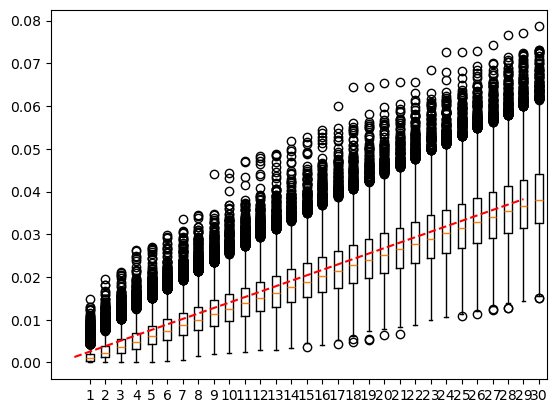

In [24]:
plt.boxplot(result['pvalues'])
n=result['counts'].mean().astype(int)
i=np.arange(1,n+1)[:30]
plt.plot(i/n, 'r--')
plt.show()

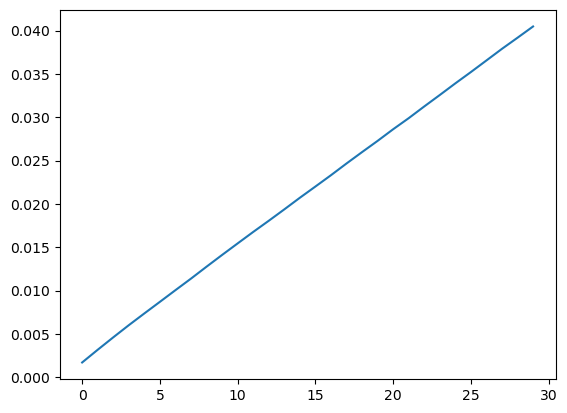

In [371]:
# plot variance of order statistics
plt.plot(result['order_stats'].mean(axis=0))
plt.show()

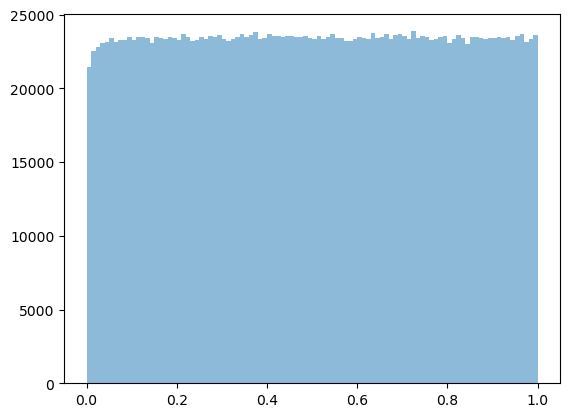

In [372]:
plt.hist(result['pvalues'], bins=100, alpha=0.5, label='p-values')
plt.show()